In [1]:
import torch
from torch import nn
import torchvision
from matplotlib.pyplot import *
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import sys
from skimage.feature import peak_local_max
from src import functions as fcts
from glob import glob


print(sys.executable)


/Users/isabellegarnreiter/opt/anaconda3/envs/vesicleSTORM/bin/python


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
kernel = np.fromfunction(lambda x, y, z: (1/(2*np.pi*sigma**2)) * np.exp((-1*((x-(kernel_size-1)/2)**2+(y-(kernel_size-1)/2)**2))/(2*sigma**2)), (kernel_size, kernel_size, kernel_size))


In [16]:
kernel = (0,1,2)
print(type(kernel))
print(kernel[0])

<class 'tuple'>
0


In [3]:
target_marker = 'PSD680'

target_directory = '/Volumes/STORM_Nathalie/STORM DeMixing/'
list_of_files = np.array([file for file in glob(target_directory + f'*{target_marker}*/*/*emix/*w*.csv')])
try:
    list_of_files = list_of_files.reshape(list_of_files.shape[0]//2,2)
except ValueError:
    print('Value Error: one channel is missing from one of the cellzones.')

zone_nb = list_of_files.shape[0]

print("shape", list_of_files.shape)

shape (54, 2)


In [305]:
ex_zone = ['/Volumes/STORM_Nathalie/STORM DeMixing/210414 DEP647_PSD680 8DIV/CellZone4/Demix/CoordTable_SAFE360_MULTIPLEXING_demixed_w1_UncertaintyFiltered.csv',
  '/Volumes/STORM_Nathalie/STORM DeMixing/210414 DEP647_PSD680 8DIV/CellZone4/Demix/CoordTable_SAFE360_MULTIPLEXING_demixed_w2_UncertaintyFiltered.csv']

vesicles = pd.read_csv(ex_zone[0])[['x [nm]', 'y [nm]', 'z [nm]']].to_numpy(dtype=np.float64)
synapse_marker = pd.read_csv(ex_zone[1])[['x [nm]', 'y [nm]', 'z [nm]']].to_numpy(dtype=np.float64)


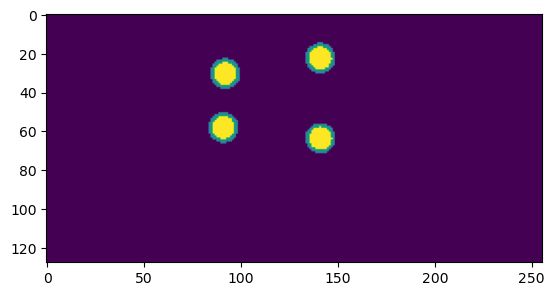

In [68]:
#create 10 images with random movements and brightness differences
from random import random

numims = 100
#torch represents as row, columns
#1 channel for data
sizedata = torch.Size([numims,*size])
#3 channels for classified
sizeclassified = torch.Size([numims,*size])
#to be faster, do in batches, need a batch dimension at the beginning
spotim = torch.empty(sizedata)
classified = torch.zeros(sizeclassified, dtype = int)

#generate the data
#generate 10 images
# need one classification image per class for classification 
for i in range(numims):
   

    #now switching to x,y for ease of thinking
    #list of lists, force to float type
    spot_pos = torch.tensor([[150.0 + (random()*10 - 10),30+ (random()*10 - 10)],[150+ (random()*10 - 10),70+ (random()*10 - 10)],[100+ (random()*10 - 10),40+ (random()*10 - 10)],[100+ (random()*10 - 10),60+ (random()*10 - 10)]])

    #create grid of indices
    #unsqueeze adds a dimension of size 1 at index zero
    xinds = torch.arange(size[1]).unsqueeze(0).expand(size)
    yinds = torch.arange(size[0]).unsqueeze(1).expand(size)

    #spot size sigma
    sigma = 5

    # need to create xinds yinds pairs, squodged together across dimension 3
    coords = torch.stack((xinds,yinds),2)

    #need to do like this takes a fuckton of memory but can run on gpu so is very fast
    # (havent gpu'd yet)
    #make coords per spot, number spots, rows, cols, number of indices
    #now have number for spot, dimension
    #both below equivalent
    #coords = coords.unsqueeze(0).expand(spot_pos.shape[0],size[0],size[1],2)
    coords = coords.unsqueeze(0).expand(spot_pos.shape[0],*size,2)
    #print(coords)

    #now expand spot_pos so has same size as coords except for not being coords
    #this is creating xc and yc everywhere
    spot_pos = spot_pos.unsqueeze(1).unsqueeze(2).expand(coords.shape)

    #now subtract the two so you have x-xc and y-yc everywhere
    #sum across last dimension to get thing for exponent
    spotim[i] = torch.exp(((-((spot_pos - coords)**2).sum(3))/(2*sigma**2))).sum(0)
    #classified[i][0] = torch.exp(((-((spot_pos - coords)**2).sum(3))/(2*sigma**2))).sum(0) < 0.3
    #classified[i][1] =  (torch.exp(((-((spot_pos - coords)**2).sum(3))/(2*sigma**2))).sum(0) > 0.3)*(torch.exp(((-((spot_pos - coords)**2).sum(3))/(2*sigma**2))).sum(0) < 0.5)
    #classified[i][2] = torch.exp(((-((spot_pos - coords)**2).sum(3))/(2*sigma**2))).sum(0) > 0.5
    
    classone = torch.zeros(torch.Size([*size]))
    classtwo = torch.zeros(torch.Size([*size]))
    
    classone =  (torch.exp(((-((spot_pos - coords)**2).sum(3))/(2*sigma**2))).sum(0) > 0.3)*(torch.exp(((-((spot_pos - coords)**2).sum(3))/(2*sigma**2))).sum(0) < 0.5)
    
    classtwo = torch.exp(((-((spot_pos - coords)**2).sum(3))/(2*sigma**2))).sum(0) > 0.5

    classified[i] = classone*1 + classtwo*2
    
clf()
imshow(classified[9])
show()
#for every spot and every pixel want to calculate centre of spot minus co-ordinates


In [61]:
classified.shape

torch.Size([100, 128, 256])

(array([6.982084e+06, 7.143310e+05, 3.985690e+05, 2.018690e+05,
        1.030910e+05, 6.036300e+04, 2.847800e+04, 1.564200e+04,
        7.374000e+03, 2.923000e+03]),
 array([   0.        ,  149.02854984,  298.05709968,  447.08564952,
         596.11419936,  745.1427492 ,  894.17129904, 1043.19984888,
        1192.22839872, 1341.25694856, 1490.2854984 ]),
 <BarContainer object of 10 artists>)

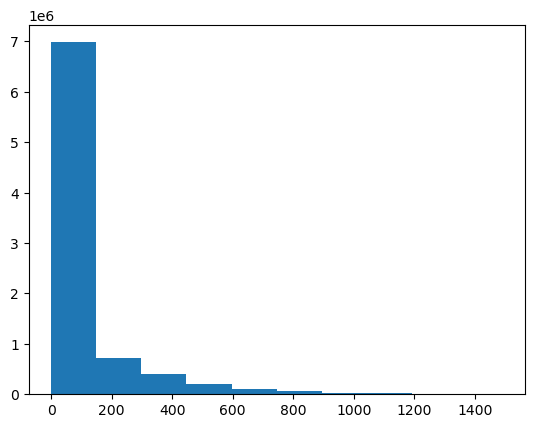

In [246]:
hist(image.flatten(), bins=10)

In [237]:
xy.shape

(45, 2)

In [58]:
spot_pos.shape

torch.Size([4, 128, 256, 2])

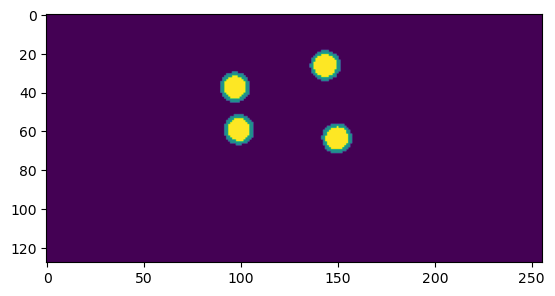

In [67]:

clf()
imshow(classified[80])
show()

In [55]:
# set up a deep learning network
class network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Kernel size is 5x5, so the shape is -2, -1, 0, 1, 2 in 1D
        # So we pad by 2 so that the output size matches the input size.
        # But run with a stride of 2 so the output is precisely half the size
        # of the input.
        #
        # Since we do this 5 times, we need the input image to be a multiple
        # of 2^5, i.e. 32.
        #
        # This is a very simple u-net. In many cases the encoder (downsampling)
        # part will be more elaborate and have several steps at the same size
        # before each downsample
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2, stride=2)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2, stride=2)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128, 256, kernel_size=5, padding=2, stride=2)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.squash_inner = nn.Conv2d(256, 128, kernel_size=1)
        self.bn_inner = nn.BatchNorm2d(128)

        
        self.conv_u4 = nn.Conv2d(256, 64, kernel_size=3, padding=1)
        self.bn_u4 = nn.BatchNorm2d(64)
        
        self.conv_u3 = nn.Conv2d(128, 32, kernel_size=3, padding=1)
        self.bn_u3 = nn.BatchNorm2d(32)
      
        self.conv_u2 = nn.Conv2d(64, 16, kernel_size=3, padding=1)
        self.bn_u2 = nn.BatchNorm2d(16)
        
        self.conv_u1 = nn.Conv2d(32, 8, kernel_size=3, padding=1)
        self.bn_u1 = nn.BatchNorm2d(8)
        
        # 3 channels out, spot type 1, spot type 2, background
        self.conv_output = nn.Conv2d(9, 3, kernel_size=3, padding=1)
 
        
    def forward(self, x):
        # Batch * 1 channel * w (multiple of 32) * h (multiple of 32)
        assert x.ndim == 4
        assert x.shape[1] == 1
        assert x.shape[2] % 32 == 0
        assert x.shape[3] % 32 == 0
        
        # d_N is downsampled, layer N
        # Assume the input is 1x128x256
        
        d1 = torch.nn.functional.relu(self.bn1(self.conv1(x)))   # 16x64x128
        d2 = torch.nn.functional.relu(self.bn2(self.conv2(d1)))  # 32x32x64
        d3 = torch.nn.functional.relu(self.bn3(self.conv3(d2)))  # 64x16x32
        d4 = torch.nn.functional.relu(self.bn4(self.conv4(d3)))  # 128x8x16
        d5 = torch.nn.functional.relu(self.bn5(self.conv5(d4)))  # 256x4x8
        
        inner = torch.nn.functional.relu(self.bn_inner(self.squash_inner(d5))) #128x4x8
        
        # Here is where unet differs from an autoencoder. An autoencoder just goes
        # down->down->down->down->squash->up->up->up->up
        # The unet does the concatenation, so it brings in high frequency information
        # from the earlier downsample layers
        
        # (inner) 128x4x8 -> (u4_in) 128x8x16
        u4_in = torch.nn.functional.interpolate(inner, scale_factor=2, mode='bilinear', align_corners=True)   
        # concat brings it to 256x8x16
        u4_concat = torch.cat((u4_in, d4), 1)
        # conv back down to 128x8x16
        u4 = torch.nn.functional.relu(self.bn_u4(self.conv_u4(u4_concat)))
               
        u3_in = torch.nn.functional.interpolate(u4, scale_factor=2, mode='bilinear', align_corners=True)        
        u3_concat = torch.cat((u3_in, d3), 1)
        u3 = torch.nn.functional.relu(self.bn_u3(self.conv_u3(u3_concat)))
        
        u2_in = torch.nn.functional.interpolate(u3, scale_factor=2, mode='bilinear', align_corners=True)        
        u2_concat = torch.cat((u2_in, d2), 1)
        u2 = torch.nn.functional.relu(self.bn_u2(self.conv_u2(u2_concat)))
        
        u1_in = torch.nn.functional.interpolate(u2, scale_factor=2, mode='bilinear', align_corners=True)        
        u1_concat = torch.cat((u1_in, d1), 1)
        u1 = torch.nn.functional.relu(self.bn_u1(self.conv_u1(u1_concat)))
        #Now up to 8x64x128
               
        # Bring it up to the final size 8x128x256
        u0_in = torch.nn.functional.interpolate(u1, scale_factor=2, mode='bilinear', align_corners=True)        
        # Concat the image input 9x128x256
        u0_concat = torch.cat((u0_in, x), 1)
        output = torch.nn.functional.softmax(self.conv_output(u0_concat), dim=1)
        
        assert output.shape == torch.Size([x.shape[0], 3, x.shape[2], x.shape[3]])
        
        return output
        
#print(classified.shape)
#n = network()
#n.forward(classified[0].unsqueeze(0).unsqueeze(0))
    

In [56]:
# need a data loader for batching, shuffling order etc
print(spotim.shape)
dataset = torch.utils.data.TensorDataset(spotim,classified)

loader = DataLoader(dataset,batch_size = 10,shuffle = True)

epochs = 3
net = network()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.0001)


#train
for epoch in range(epochs):
    
    for batchno, (images,classifications) in enumerate(loader):
        #print(images.shape)
        #print(images.ndim)
        images = images.unsqueeze(1)
        print(images.shape)
        optimizer.zero_grad()
        result = net(images)
        #BCE for 2 classes, func x ent for xple classes
        # cross entropy loss
        #print(result.shape)
        #print(classifications.shape)
        #print(classifications.max())
        #print(classifications.min())
        loss = torch.nn.functional.cross_entropy(result,classifications)
        #loss = nn.CrossEntropyLoss()
        
        #loss = (images,classifications)
        loss.backward()
        optimizer.step()


torch.Size([100, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])
torch.Size([10, 1, 128, 256])


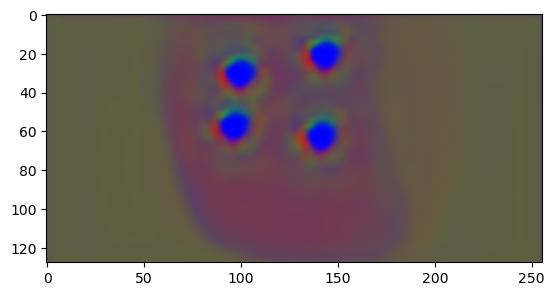

In [70]:
clf
testimage = images[0,0].unsqueeze(0).unsqueeze(0)
testout = net(testimage)
testout = testout.squeeze(0).squeeze(0)
#detach from gradient computation - can't convert to numpy when have gradients
testout = testout.detach()
#matplotlib expects width, height, channels
testout = testout.permute(1,2,0)
imshow(testout)
show()